# Hello hello,
Welcome to the JQ Model Aquarium, the (future)? home of many models whose intelligence is comparable to the average goldfish

USING SGD AND DECAY = 0.9 EVERY 100 EPOCHS FOR 500 EPOCHS

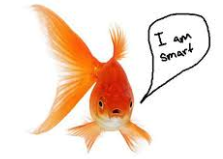

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import gc
import torchnet as tnt
from tqdm import tqdm_notebook # for-loop progress bar in notebook

# plt setup and the gpu setup
plt.ion()
use_gpu = torch.cuda.is_available()

In [2]:
print(use_gpu) #hallelujah

True


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224), #apparently get an error if dont have this line
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),    
        transforms.Grayscale(),    
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    
    'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

data_dir = '/home/jquach12/jq_shenanigans/data/blackAndWhite_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation','testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation','testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation','testing']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

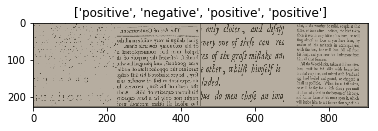

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [5]:
# ========================================
# Step 4. define the training process.
#
# TODO: The basic process of train and validation is defined. Please implement the overall average validation 
# confusion matrix, meaning for each validation (after running all epochs), get the confusion matrix for that book,
# repeat this for the rest of 10 books. THen get the overall performance. Also, implement the early-stop as you
# originally has in your code. :) I removed them here for clarity. You can add them back. 
# ========================================



trainLosses = []
valLosses = []
def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):

    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # looping parameters
        running_loss = 0.0
        
        
        confusion_matrix = tnt.meter.ConfusionMeter(2)
        
        # loop through train and val phase in each epoch
        for phase in ['train', 'validation']:
            # check train or val
            if phase == 'train':                
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # Iterate over each book
            running_loss = 0.0
            
         
            confusion_matrix = tnt.meter.ConfusionMeter(2)
            for book in tqdm_notebook(data_loaders[phase]):
                for data in data_loaders[phase][book]:
                    # get the inputs;  wrap them in Variable and make them into gpu or not
                    inputs, labels = data # input size: [5, 1, 28, 28] ; keep the dummy color channel:1
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    # back
                    if phase == 'train': 
                        loss.backward()
                        optimizer.step()

                    # Add to confusion matrix
                    confusion_matrix.add(outputs.data, labels.data)

                    # statistics
                   
                    running_loss += loss.item()
                    
            
            # report evaluation
            print('Phase:%s' %phase)
            print('Confusion matrix:\n', confusion_matrix.conf)
            if phase == 'train':
                print('train loss', running_loss)
                trainLosses.append(running_loss)
               
            else:
                print('validation loss', running_loss)
                valLosses.append(running_loss)
               
            
        
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
def plotLosses(trainLosses,valLosses,title = ""):
    plt.title(title)
    plt.plot(trainLosses,label = "training")
    plt.plot(valLosses,label = "validation")
    #plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

#plotLosses(trainLosses,valLosses,"JQ_MODEL")

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cuda()
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cuda()
        self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cuda()
        self.conv2_drop = nn.Dropout2d(p = 0.2)
        self.conv3_drop = nn.Dropout2d(p = 0.1)
      
        #assumes a batch size of 50
        self.fc1 = nn.Linear(31360,64).cuda()
        self.fc2 = nn.Linear(64, 25).cuda()
        self.fc3 = nn.Linear(25,2).cuda()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        #return x

In [9]:
trainLosses = []
valLosses = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    
    for epoch in range(num_epochs):
        cm_posAndNeg = tnt.meter.ConfusionMeter(2)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                if phase == 'validation':
                    cm_posAndNeg.add(outputs.data, labels.data)
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                trainLosses.append(epoch_loss)
            elif phase == 'validation':
                valLosses.append(epoch_loss)
                
            if phase == 'validation':
                print('Confusion matrix:\n', cm_posAndNeg.conf)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model #got really high acc when if phase == 'val' i.e. this never happens
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
net1 = Net1()

In [ ]:


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum = 0.9) #set lr a little high to decay later

# Decay LR by a factor of 0.9 every 100 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

In [ ]:
num_epochs = 500
net1 = train_model(net1, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 1/500
----------
train Loss: 0.6993 Acc: 0.4704
Confusion matrix:
 [[  0 168]
 [  0 168]]
validation Loss: 0.6931 Acc: 0.5000

Epoch 2/500
----------
train Loss: 0.6933 Acc: 0.5142
Confusion matrix:
 [[  0 168]
 [  0 168]]
validation Loss: 0.6918 Acc: 0.5000

Epoch 3/500
----------
train Loss: 0.6937 Acc: 0.5107
Confusion matrix:
 [[ 71  97]
 [  7 161]]
validation Loss: 0.6906 Acc: 0.6905

Epoch 4/500
----------
train Loss: 0.6874 Acc: 0.5628
Confusion matrix:
 [[167   1]
 [167   1]]
validation Loss: 0.6898 Acc: 0.5000

Epoch 5/500
----------
train Loss: 0.6852 Acc: 0.5628
Confusion matrix:
 [[168   0]
 [168   0]]
validation Loss: 0.6936 Acc: 0.5000

Epoch 6/500
----------
train Loss: 0.6925 Acc: 0.5083
Confusion matrix:
 [[ 76  92]
 [ 37 131]]
validation Loss: 0.6863 Acc: 0.6161

Epoch 7/500
----------
train Loss: 0.6803 Acc: 0.5592
Confusion matrix:
 [[ 23 145]
 [  3 165]]
validation Loss: 0.6767 Acc: 0.5595

Epoch 8/500
----------
train Loss: 0.6802 Acc: 0.5818
Confusion matri

Confusion matrix:
 [[143  25]
 [  5 163]]
validation Loss: 0.4113 Acc: 0.9107

Epoch 63/500
----------
train Loss: 0.4981 Acc: 0.7761
Confusion matrix:
 [[120  48]
 [  2 166]]
validation Loss: 0.4841 Acc: 0.8512

Epoch 64/500
----------
train Loss: 0.5065 Acc: 0.7784
Confusion matrix:
 [[111  57]
 [  3 165]]
validation Loss: 0.5097 Acc: 0.8214

Epoch 65/500
----------
train Loss: 0.4662 Acc: 0.8033
Confusion matrix:
 [[134  34]
 [  6 162]]
validation Loss: 0.4650 Acc: 0.8810

Epoch 66/500
----------
train Loss: 0.4609 Acc: 0.7962
Confusion matrix:
 [[136  32]
 [  5 163]]
validation Loss: 0.4088 Acc: 0.8899

Epoch 67/500
----------
train Loss: 0.4777 Acc: 0.7796
Confusion matrix:
 [[120  48]
 [  4 164]]
validation Loss: 0.4649 Acc: 0.8452

Epoch 68/500
----------
train Loss: 0.4641 Acc: 0.7974
Confusion matrix:
 [[129  39]
 [  2 166]]
validation Loss: 0.4510 Acc: 0.8780

Epoch 69/500
----------
train Loss: 0.4646 Acc: 0.8009
Confusion matrix:
 [[136  32]
 [  6 162]]
validation Loss: 0.4

In [ ]:
plt.plot(trainLosses,label = "train")
plt.plot(valLosses,label = "validation")
plt.title("Losses over " + str(num_epochs) +  " Epochs")
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
visualize_model(net1,4)

plt.ioff()
plt.show()

In [ ]:
torch.save(net1.state_dict(), '/home/jquach12/net1_weight500ep.pt')
torch.save(net1, '/home/jquach12/net1_model500ep.pt')